## ====================================================================================

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import entropy
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [2]:
# Function to calculate KL Divergence
def kl_divergence(p, q, epsilon=1e-10):
    """
    Calculates KL divergence between two probability distributions.
    Args:
        p (np.array): Probability distribution of reference data.
        q (np.array): Probability distribution of incoming data.
        epsilon (float): Small value to avoid log(0).
    Returns:
        float: KL Divergence between distributions.
    """
    p = p + epsilon  # to avoid division by zero
    q = q + epsilon  # to avoid division by zero
    return entropy(p, q)

# Function to create histograms for data and normalize to probability distribution
def calculate_histogram(data, bins=50):
    """
    Creates a histogram and converts it to a probability distribution.
    Args:
        data (np.array): The data for which to compute the histogram.
        bins (int): Number of histogram bins.
    Returns:
        np.array: Normalized histogram (probability distribution).
    """
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    return hist / np.sum(hist), bin_edges



In [3]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

class FEDD:
    def __init__(self, window_size=300, lambda_value=0.2, warning_threshold=1.0, drift_threshold=1.5, metric='cosine'):
        self.window_size = window_size
        self.lambda_value = lambda_value
        self.warning_threshold = warning_threshold
        self.drift_threshold = drift_threshold
        self.metric = metric
        self.feature_vector_init = None
        self.drift_detected = False

    def compute_features(self, data):
        # Autocorrelation at first five lags
        autocorr = [np.corrcoef(data[:-lag], data[lag:])[0, 1] for lag in range(1, 6)]
        
        # Variance
        variance = np.var(data)
        
        # Skewness
        skewness = np.mean((data - np.mean(data))**3) / np.std(data)**3
        
        # Kurtosis
        kurtosis = np.mean((data - np.mean(data))**4) / np.std(data)**4
        
        # Combine features into vector
        feature_vector = np.hstack((autocorr, variance, skewness, kurtosis))
        return feature_vector

    def distance(self, v1, v2):
        if self.metric == 'cosine':
            return 1 - cosine_similarity([v1], [v2])[0][0]
        elif self.metric == 'pearson':
            return 1 - pearsonr(v1, v2)[0]

    def update_EWMA(self, dist, prev_EWMA, count):
        return (1 - self.lambda_value) * prev_EWMA + self.lambda_value * dist if count > 0 else dist

    def detect_drift(self, data_stream):
        warning_signal = False
        count = 0
        EWMA_dist = 0
        below_warn = 0
        for i in range(len(data_stream) - self.window_size):
            current_window = data_stream[i:i + self.window_size]
            feature_vector = self.compute_features(current_window)
            
            if self.feature_vector_init is None:
                self.feature_vector_init = feature_vector
                continue

            dist = self.distance(self.feature_vector_init, feature_vector)
            EWMA_dist = self.update_EWMA(dist, EWMA_dist, count)
            count += 1

            # Check for warning signal
            if not warning_signal and EWMA_dist > (self.warning_threshold * np.std(EWMA_dist)):
                warning_signal = True
                print(f"Warning at index {i}")

            # Check for drift signal
            if EWMA_dist > (self.drift_threshold * np.std(EWMA_dist)):
                self.drift_detected = True
                print(f"Drift detected at index {i}")
                break

            # Reset warning if stable for some time
            if warning_signal and EWMA_dist < (self.warning_threshold * np.std(EWMA_dist)):
                below_warn += 1
                if below_warn >= 10:
                    warning_signal = False
                    below_warn = 0


In [4]:
# Generate synthetic reference data and incoming data stream
np.random.seed(42)
reference_data = np.random.normal(loc=0.0, scale=1.0, size=(1000, 3))  # reference data (3 features)
incoming_data_normal = np.random.normal(loc=0.0, scale=1.0, size=(100, 3))  # normal incoming data
incoming_data_drift = np.random.normal(loc=2.0, scale=1.0, size=(100, 3))  # data after concept drift

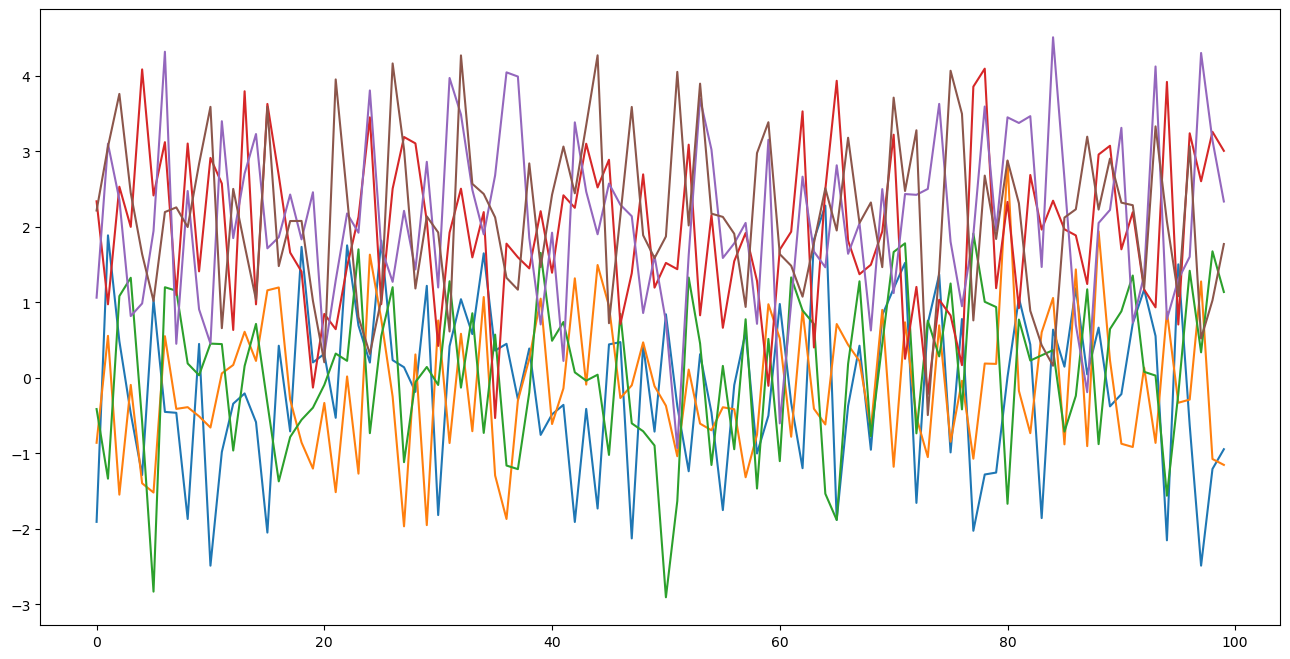

In [5]:
plt.figure(figsize=(16,8))
# plt.plot(reference_data)
plt.plot(incoming_data_normal)
plt.plot(incoming_data_drift)
plt.show()

In [6]:
# Function to detect concept drift using KL Divergence
def detect_concept_drift(reference_data, incoming_data, threshold=0.5, bins=50):
    """
    Detects concept drift by comparing KL Divergence between reference and incoming data.
    Args:
        reference_data (np.array): Reference data (before drift).
        incoming_data (np.array): Incoming data stream (current data).
        threshold (float): KL Divergence threshold for detecting drift.
        bins (int): Number of bins for the histograms.
    Returns:
        list: KL divergence values for each feature and drift detection status.
    """
    num_features = reference_data.shape[1]
    kl_values = []
    drift_detected = False
    
    for feature_idx in range(num_features):
        ref_hist, _ = calculate_histogram(reference_data[:, feature_idx], bins)
        inc_hist, _ = calculate_histogram(incoming_data[:, feature_idx], bins)
        kl_div = kl_divergence(ref_hist, inc_hist)
        kl_values.append(kl_div)
        
        if kl_div > threshold:
            drift_detected = True
    
    return kl_values, drift_detected



In [7]:
# Detect drift between reference data and incoming data (normal and drifted)
kl_values_normal, drift_detected_normal = detect_concept_drift(reference_data, incoming_data_normal)
kl_values_drift, drift_detected_drift = detect_concept_drift(reference_data, incoming_data_drift)

# Output the results
print("KL Divergence (Normal Data):", kl_values_normal)
print("Drift Detected (Normal Data):", drift_detected_normal)
print("\nKL Divergence (Drifted Data):", kl_values_drift)
print("Drift Detected (Drifted Data):", drift_detected_drift)


KL Divergence (Normal Data): [3.2315022533901967, 1.9098835079593113, 1.7312824187668565]
Drift Detected (Normal Data): True

KL Divergence (Drifted Data): [1.3956453510809823, 1.1797795072124682, 1.4571972208374457]
Drift Detected (Drifted Data): True


In [8]:
data_stream = np.random.normal(size=1000)  # Simulated time series data
fedd = FEDD(window_size=100, metric='pearson')
fedd.detect_drift(incoming_data_drift)


In [9]:
sample_test = pd.read_parquet("../datasets/3W/dataset/2/SIMULATED_00005.parquet")
sample_test = sample_test[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']]

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in sample_test.columns if col.startswith('P')]
sample_test[pressure_columns] = sample_test[pressure_columns] / 10**6   

# sample_test = pd.read_csv('../../datasets/3W/dataset_processed/csv/2/WELL-00011_20141006150121.csv', index_col='timestamp')
# sample_test.dropna(inplace=True)
sample_test['class'].fillna(value=0, inplace=True) 
sample_test_class = sample_test['class']
sample_test_np = sample_test.drop('class',axis=1).values

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/3W/dataset/2/SIMULATED_00005.parquet'

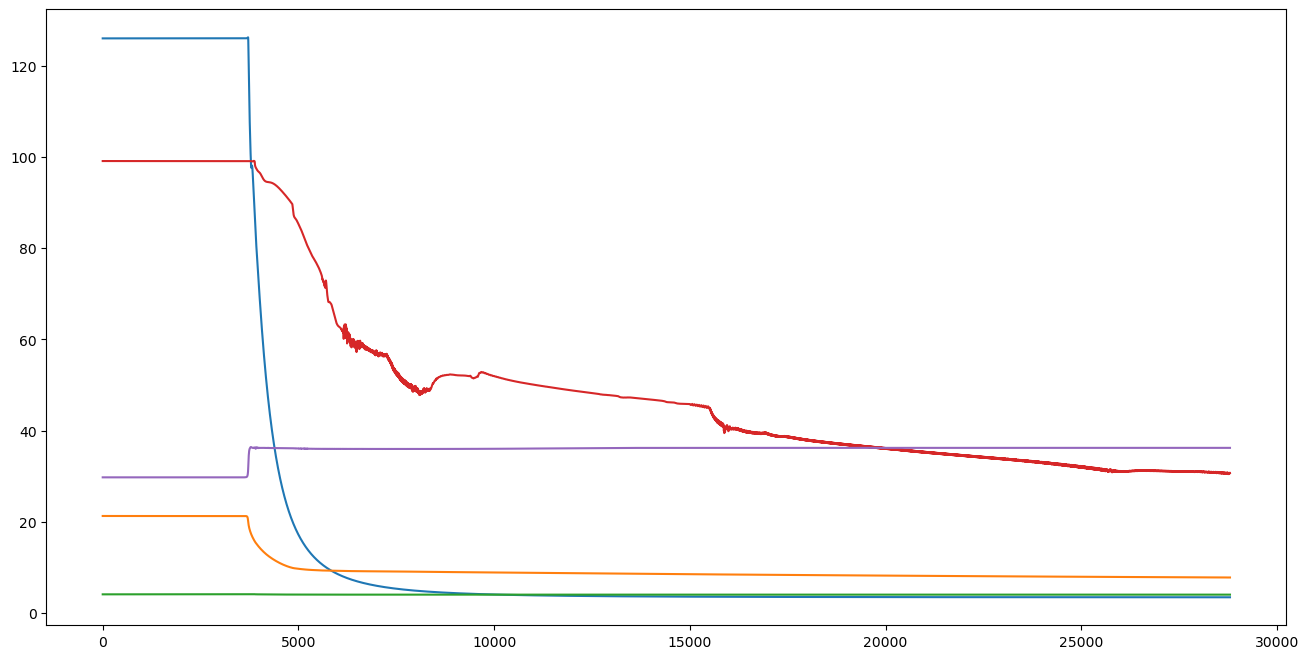

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(range(len(sample_test_np)),sample_test_np)
plt.show()

## ==========================================================================

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import entropy
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [3]:
import os
from menelaus.change_detection import ADWIN, CUSUM, PageHinkley
from menelaus.data_drift import CDBD, HDDDM, PCACD, KdqTreeStreaming, KdqTreeBatch
from menelaus.datasets import fetch_circle_data, fetch_rainfall_data

## ==========================================================================

In [3]:
merged_r_e = pd.DataFrame()
rel_r_e = pd.DataFrame()
r_e_path = "../../reconstruction_error/LSTM-Autoencoder-2"

for r_e in os.listdir(r_e_path):
    print(r_e)
    df = pd.read_csv(os.path.join(r_e_path, r_e))
    re_df = df / df.sum() * 100
    merged_r_e = pd.concat([merged_r_e, df])
    rel_r_e = pd.concat([rel_r_e, re_df])

merged_r_e = merged_r_e.reset_index().drop("index", axis=1)

selected_instance_0.csv
selected_instance_4.csv
selected_instance_2.csv


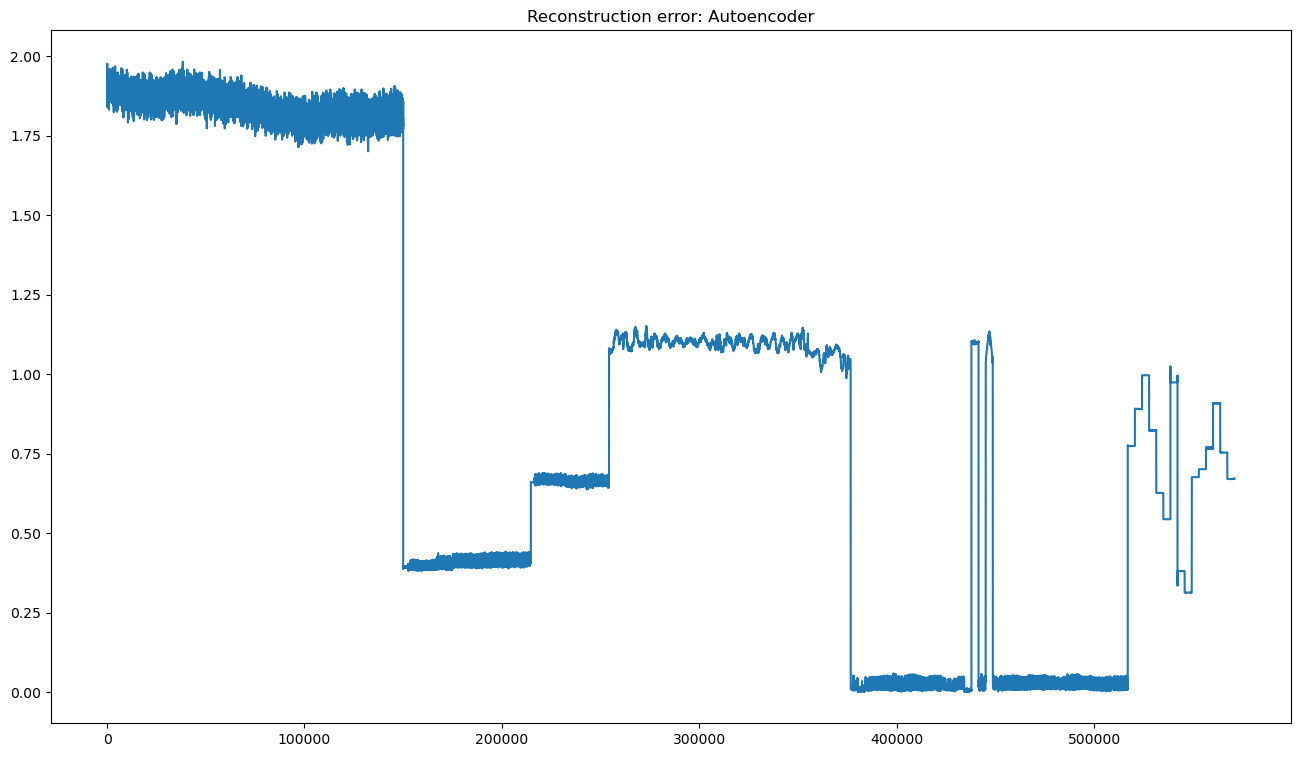

In [4]:
plt.figure(figsize=(16,9))
plt.plot(merged_r_e.loc[:, '0'])
# plt.plot(np.full(len(merged_r_e), np.mean(merged_r_e)))
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.linspace(thres-iqr, thres+iqr, 100), r_e.shape[0], color='blue', alpha=0.3)
plt.title("Reconstruction error: Autoencoder")

plt.show()

In [5]:
# # read in Circle dataset
# df = fetch_circle_data()
# drift_start, drift_end = 1000, 1250

# rainfall_df = fetch_rainfall_data()

In [6]:
# rainfall_df.plot(figsize=(16,9))

In [7]:
merged_r_e.shape

(571071, 1)

In [27]:
adwin = ADWIN(new_sample_thresh=500, delta=1e-5, window_size_thresh=50, subwindow_size_thresh=30, max_buckets=5)

# setup DF to record results
status = pd.DataFrame(columns=["index", "actual value", "drift_detected", "ADWIN mean"])
df2 = pd.Series(merged_r_e.loc[240000:260000,'0'].values)
rec_list = []

# iterate through data; feed each sample to the detector, in turn
for i in range(len(df2)):
    obs = df2[i]
    adwin.update(X=obs)
    status.loc[i] = [i, obs, adwin.drift_state, adwin.mean()]

    #monitor the size of ADWIN's window as it changes
    if adwin.drift_state == "drift":
        retrain_start = adwin.retraining_recs[0]
        retrain_end = adwin.retraining_recs[1]
        rec_list.append([retrain_start, retrain_end])

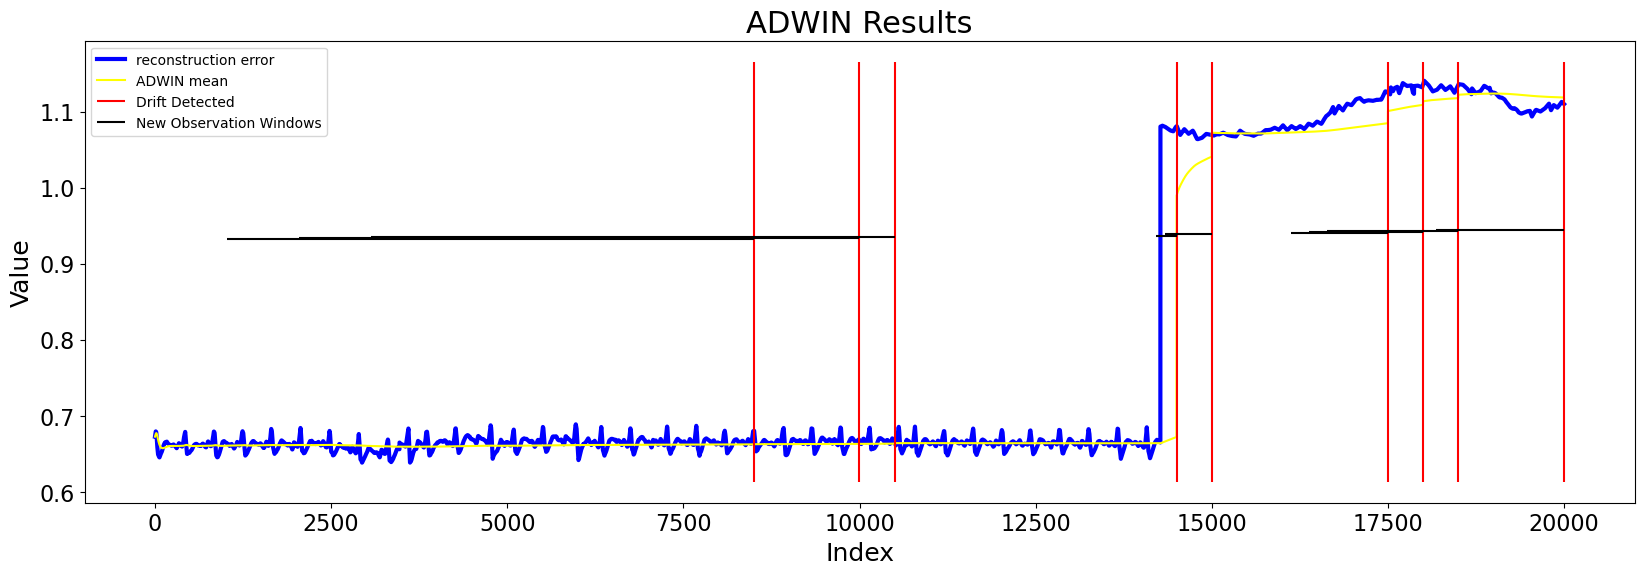

In [28]:
# plot the monitored variable and the status of the detector
plt.figure(figsize=(20, 6))
plt.plot("index", "actual value", data=status, color='blue', linewidth=3, label='reconstruction error')
plt.plot("index", "ADWIN mean", data=status, color='yellow')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADWIN Results", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
# ylims = [-2, 6]
# plt.ylim(ylims)
xmin, xmax, ymin, ymax = plt.axis()

plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ymin,
    ymax=ymax,
    label="Drift Detected",
    color="red",
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.6 * (ymax - ymin) + ymin,
    stop=0.8 * ymax,
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"][::-1],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="black",
    label="New Observation Windows",
)

plt.legend()
# plt.xlim((0, 10000))
plt.show()

In [25]:
## Setup ##

# kdqTree does use bootstrapping to define its critical thresholds, so setting
# the seed is important to reproduce exact behavior.
np.random.seed(1)

# Note that the default input_type for KDQTree is "stream".
# The window size, corresponding to the portion of the stream which KDQTree
# monitors, must be specified.
det = KdqTreeStreaming(window_size=500, alpha=5e-5, bootstrap_samples=500, count_ubound=50)

# setup DF to record results
status = pd.DataFrame(columns=["index", "val1", "drift_detected"])

# iterate through X data and run detector
data = pd.DataFrame(merged_r_e.loc[240000:260000,'0'].values, columns=['val1'])

In [19]:
data.columns

Index(['val1'], dtype='object')

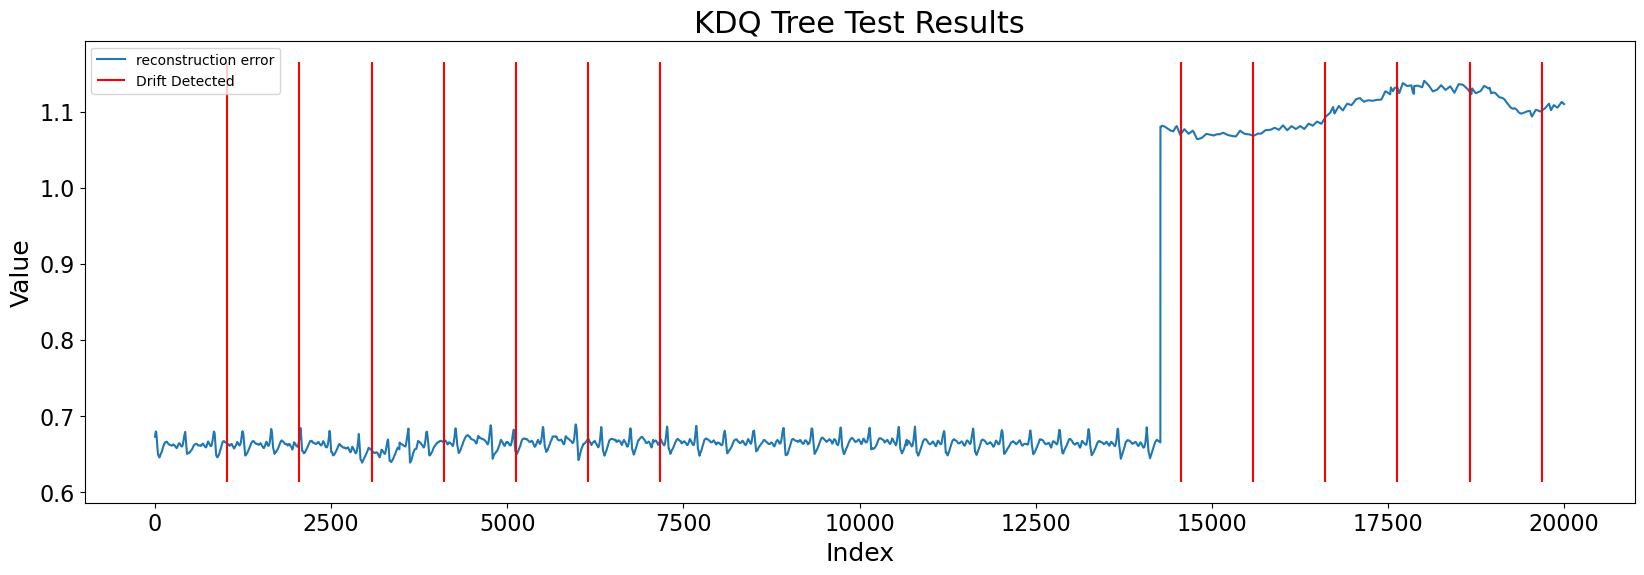

In [26]:
plot_data = {}
for i in range(len(data)):
    det.update(data.iloc[[i]])
    status.loc[i] = [i, data.iloc[i, 0], det.drift_state]
    if det.drift_state is not None:
        # capture the visualization data
        plot_data[i] = det.to_plotly_dataframe()

plt.figure(figsize=(20, 6))
# plt.plot("index", "var2", data=status, label="var2")
plt.plot("index", "val1", data=status, label="reconstruction error")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("KDQ Tree Test Results", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)

xmin, xmax, ymin, ymax = plt.axis()

# plt.axvspan(drift_start, drift_end, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ymin,
    ymax=ymax,
    label="Drift Detected",
    color="red",
)

plt.legend()
plt.show()

In [13]:
# from menelaus.datasets import make_example_batch_data

# example_data = make_example_batch_data()

In [22]:
reference = merged_r_e.loc[200000:220000-1, '0']
all_test = merged_r_e.loc[240000:260000-1, '0']

chunk_size = 500
chunks = [all_test.iloc[i:i+chunk_size] for i in range(0, len(all_test), chunk_size)]

# Run CDBD
cdbd = CDBD(subsets=5, significance=0.05)
cdbd.set_reference(reference)


In [23]:
# Store drift for test statistic plot
detected_drift = []
for i, chunk in enumerate(chunks):
    cdbd.update(chunks[i])
    detected_drift.append(cdbd.drift_state)

In [16]:
# ## Setup ##

# # Set up reference and test batches, using 2007 as reference year
# reference = pd.DataFrame(example_data[example_data.year == 2007].loc[:, "confidence"])
# all_test = example_data[example_data.year != 2007]

# # Run CDBD
# cdbd = CDBD(subsets=8)
# cdbd.set_reference(reference)

# # Store drift for test statistic plot
# detected_drift = []
# for year, subset_data in all_test.groupby("year"):
#     cdbd.update(pd.DataFrame(subset_data.loc[:, "confidence"]))
#     detected_drift.append(cdbd.drift_state)

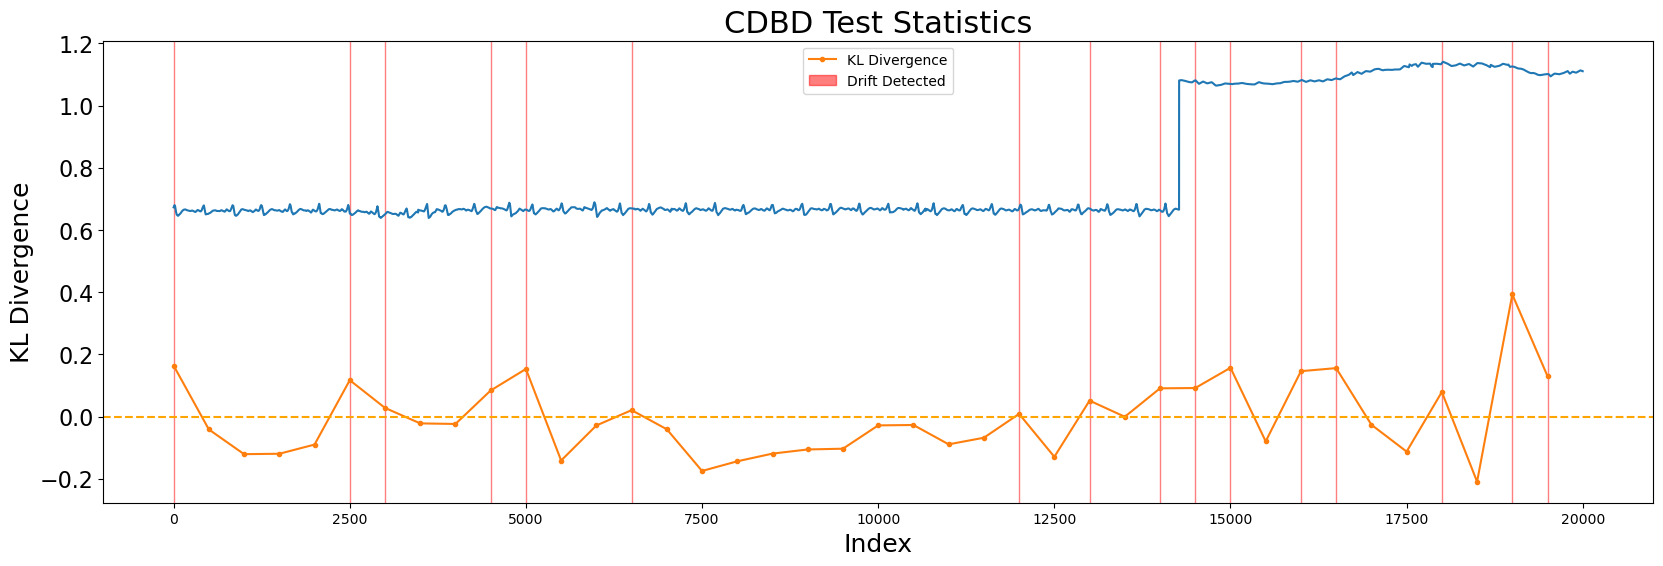

In [24]:
## Plot Line Graph ##
# Calculate divergences for all years in dataset
index = list(range(len(chunks)))
for i in range(len(index)):
    index[i] = index[i] * chunk_size
    

kl_divergence = [
    ep - th for ep, th in zip(cdbd.epsilon_values.values(), cdbd.thresholds.values())
]

# Remove potential infs that arise because of small confidence scores
kl_divergence = [
    x if np.isnan(x) == False and np.isinf(x) == False else 0 for x in kl_divergence
]

# Plot KL Divergence against Year, along with detected drift
plot_data = pd.DataFrame(
    {"Index": index, "KL Divergence": kl_divergence, "Detected Drift": detected_drift}
)
# sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot(range(len(all_test)),all_test)
plt.plot("Index", "KL Divergence", data=plot_data, label="KL Divergence", marker=".")
plt.grid(False, axis="x")
plt.yticks(fontsize=16)
plt.title("CDBD Test Statistics", fontsize=22)
plt.ylabel("KL Divergence", fontsize=18)
plt.xlabel("Index", fontsize=18)
# plt.ylim([min(kl_divergence) - 0.02, max(kl_divergence) + 0.02])
for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Index"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")

plt.show()

## ==========================================================================

In [21]:
merged_r_e = pd.read_csv("../../reconstruction_error/gearbox/reconstruction_error.csv")
merged_r_e = merged_r_e.reset_index().drop("index", axis=1)

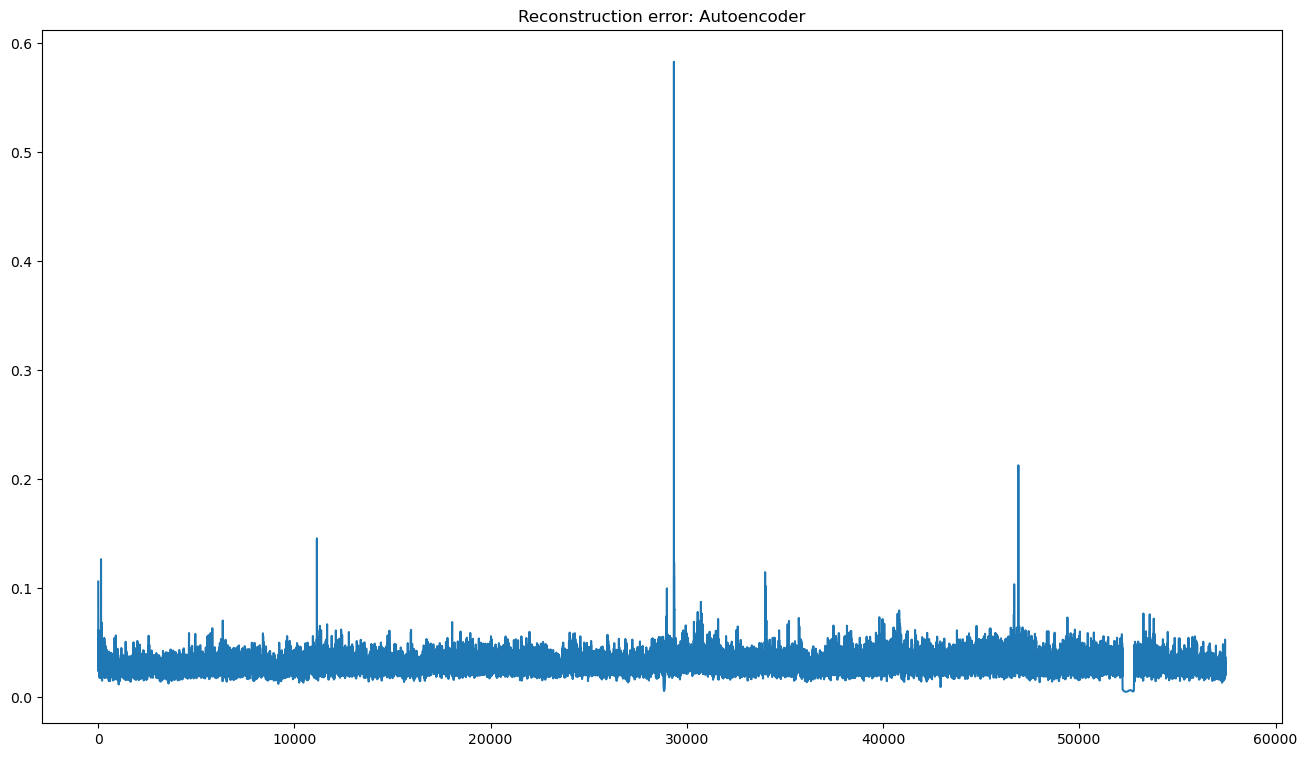

In [5]:
plt.figure(figsize=(16,9))
plt.plot(merged_r_e.loc[:, '0'])
# plt.plot(np.full(len(merged_r_e), np.mean(merged_r_e)))
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.linspace(thres-iqr, thres+iqr, 100), r_e.shape[0], color='blue', alpha=0.3)
plt.title("Reconstruction error: Autoencoder")

plt.show()

In [22]:
adwin = ADWIN(new_sample_thresh=100, delta=1e-5, window_size_thresh=50, subwindow_size_thresh=30, max_buckets=5)

# setup DF to record results
status = pd.DataFrame(columns=["index", "actual value", "drift_detected", "ADWIN mean"])
df2 = pd.Series(merged_r_e.loc[:,'0'].values)
rec_list = []

# iterate through data; feed each sample to the detector, in turn
for i in range(len(df2)):
    obs = df2[i]
    adwin.update(X=obs)
    status.loc[i] = [i, obs, adwin.drift_state, adwin.mean()]

    #monitor the size of ADWIN's window as it changes
    if adwin.drift_state == "drift":
        retrain_start = adwin.retraining_recs[0]
        retrain_end = adwin.retraining_recs[1]
        rec_list.append([retrain_start, retrain_end])

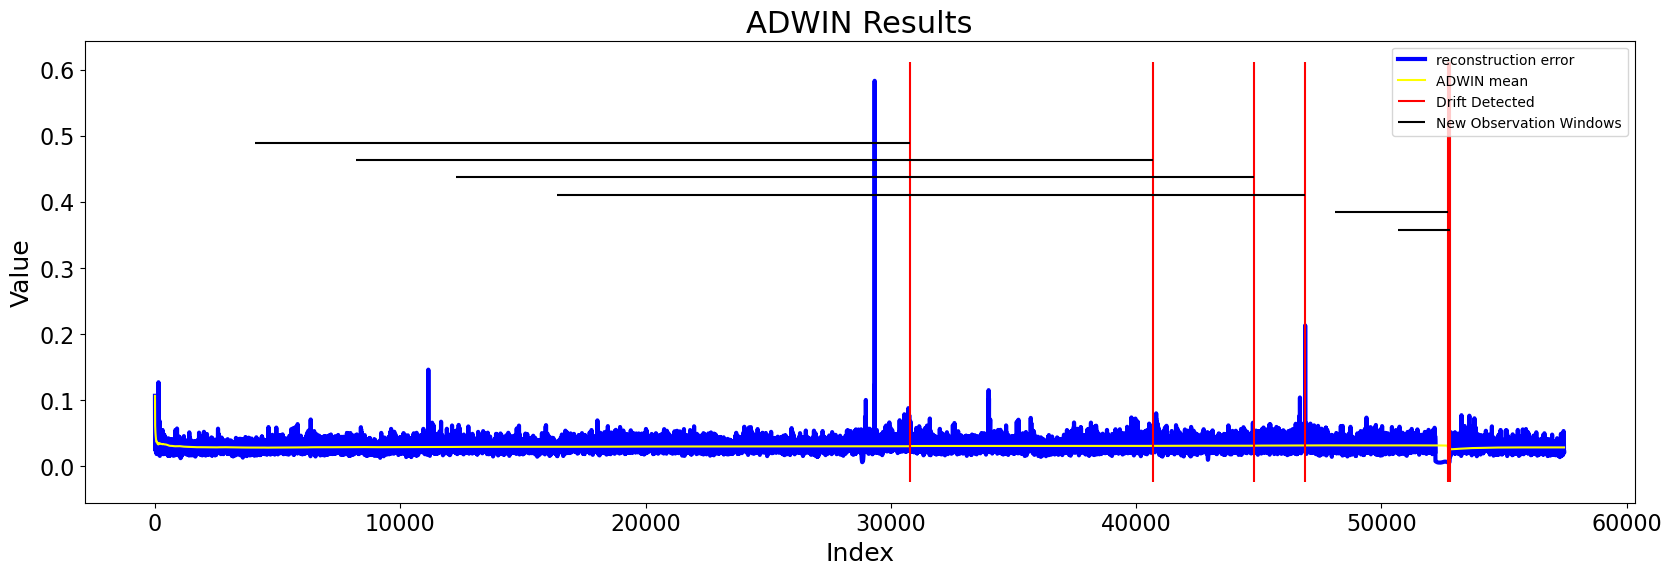

In [23]:
# plot the monitored variable and the status of the detector
plt.figure(figsize=(20, 6))
plt.plot("index", "actual value", data=status, color='blue', linewidth=3, label='reconstruction error')
plt.plot("index", "ADWIN mean", data=status, color='yellow')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADWIN Results", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
# ylims = [-2, 6]
# plt.ylim(ylims)
xmin, xmax, ymin, ymax = plt.axis()

plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ymin,
    ymax=ymax,
    label="Drift Detected",
    color="red",
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.6 * (ymax - ymin) + ymin,
    stop=0.8 * ymax,
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"][::-1],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="black",
    label="New Observation Windows",
)

plt.legend()
# plt.xlim((0, 10000))
plt.show()

In [19]:
## Setup ##

# kdqTree does use bootstrapping to define its critical thresholds, so setting
# the seed is important to reproduce exact behavior.
np.random.seed(1)

# Note that the default input_type for KDQTree is "stream".
# The window size, corresponding to the portion of the stream which KDQTree
# monitors, must be specified.
det = KdqTreeStreaming(window_size=1000, alpha=5e-5, bootstrap_samples=500, count_ubound=50)

# setup DF to record results
status = pd.DataFrame(columns=["index", "val1", "drift_detected"])

# iterate through X data and run detector
data = pd.DataFrame(merged_r_e.loc[:,'0'].values, columns=['val1'])

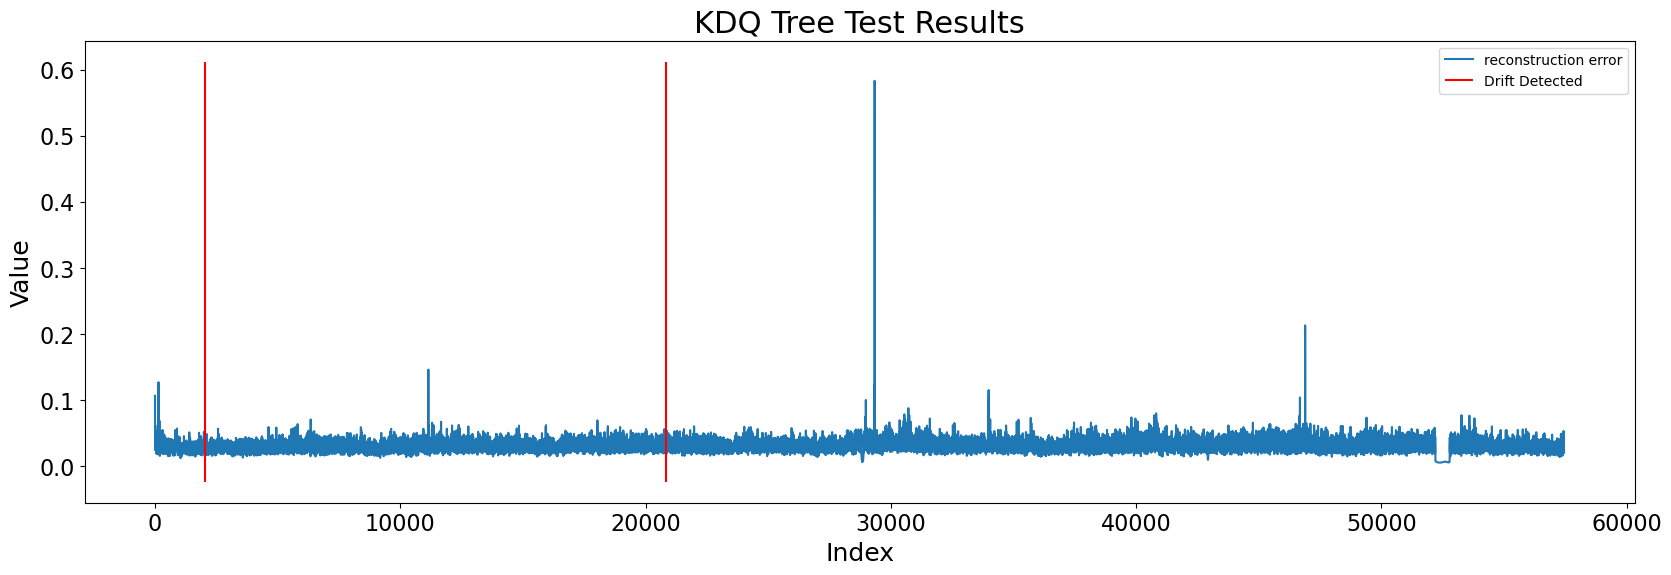

In [20]:
plot_data = {}
for i in range(len(data)):
    det.update(data.iloc[[i]])
    status.loc[i] = [i, data.iloc[i, 0], det.drift_state]
    if det.drift_state is not None:
        # capture the visualization data
        plot_data[i] = det.to_plotly_dataframe()

plt.figure(figsize=(20, 6))
# plt.plot("index", "var2", data=status, label="var2")
plt.plot("index", "val1", data=status, label="reconstruction error")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("KDQ Tree Test Results", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)

xmin, xmax, ymin, ymax = plt.axis()

# plt.axvspan(drift_start, drift_end, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ymin,
    ymax=ymax,
    label="Drift Detected",
    color="red",
)

plt.legend()
plt.show()

In [11]:
reference = merged_r_e.loc[:30000, '0']
all_test = merged_r_e.loc[30000:, '0']

chunk_size = 500
chunks = [all_test.iloc[i:i+chunk_size] for i in range(0, len(all_test), chunk_size)]

# Run CDBD
cdbd = CDBD(subsets=5, significance=0.05)
cdbd.set_reference(reference)


In [13]:
# Store drift for test statistic plot
detected_drift = []
for i, chunk in enumerate(chunks):
    cdbd.update(chunks[i])
    detected_drift.append(cdbd.drift_state)

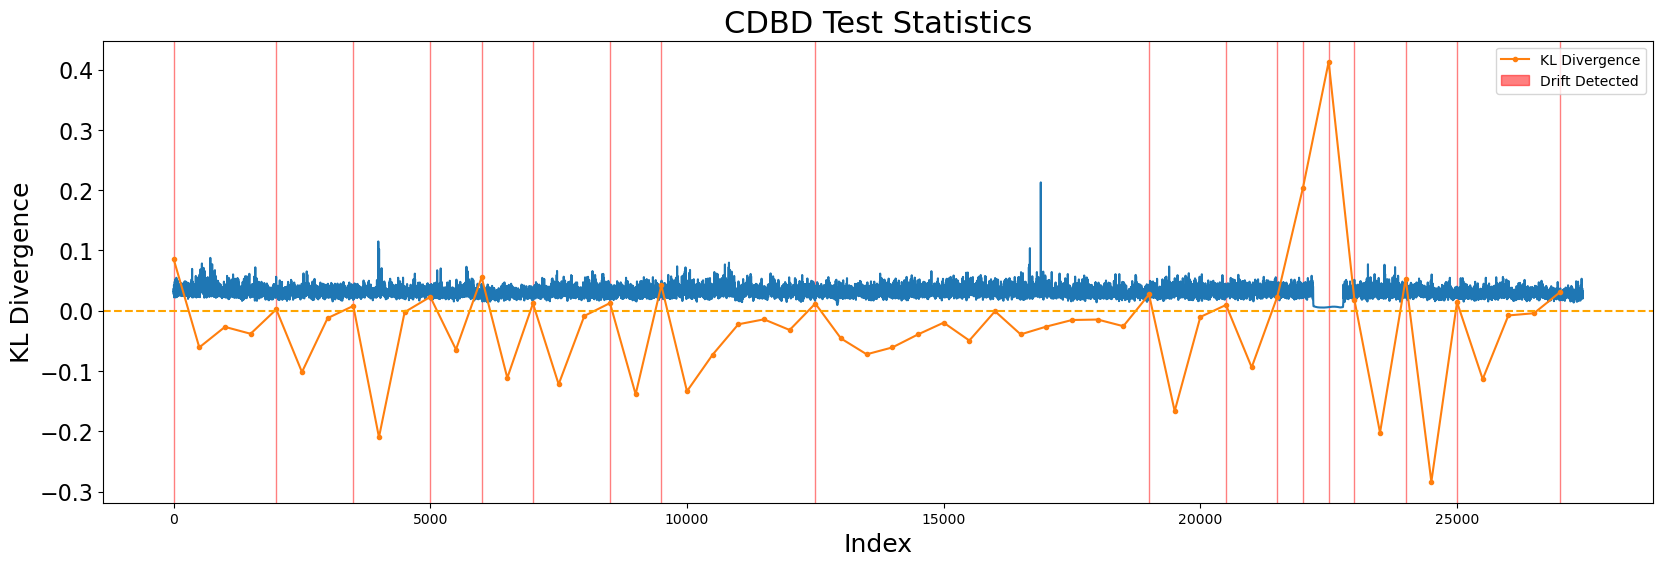

In [14]:
## Plot Line Graph ##
# Calculate divergences for all years in dataset
index = list(range(len(chunks)))
for i in range(len(index)):
    index[i] = index[i] * chunk_size
    

kl_divergence = [
    ep - th for ep, th in zip(cdbd.epsilon_values.values(), cdbd.thresholds.values())
]

# Remove potential infs that arise because of small confidence scores
kl_divergence = [
    x if np.isnan(x) == False and np.isinf(x) == False else 0 for x in kl_divergence
]

# Plot KL Divergence against Year, along with detected drift
plot_data = pd.DataFrame(
    {"Index": index, "KL Divergence": kl_divergence, "Detected Drift": detected_drift}
)
# sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot(range(len(all_test)),all_test)
plt.plot("Index", "KL Divergence", data=plot_data, label="KL Divergence", marker=".")
plt.grid(False, axis="x")
plt.yticks(fontsize=16)
plt.title("CDBD Test Statistics", fontsize=22)
plt.ylabel("KL Divergence", fontsize=18)
plt.xlabel("Index", fontsize=18)
# plt.ylim([min(kl_divergence) - 0.02, max(kl_divergence) + 0.02])
for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Index"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")
plt.show()